# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- **качество предсказания;**
- **скорость предсказания;**
- **время обучения.**

___
В датасете представлены колонки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price (Целевой признак) — цена (евро)

___
Задачи и цели:

- Загрузить библиотеки и данные
- Провести предобработку
- Проанализировать целевой признак и числовые данные на аномалии
- Построить матрицу корреляции и проверить признаки на мультиколлинеарность
- Построить и проанализировать модели
- Сделать выводы и дать рекомендации закасчику, согласно его требованиям

## Загрузка и Подготовка данных

In [1]:
!pip install phik

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

from phik import phik_matrix
from phik.report import plot_correlation_matrix

pd.set_option('display.float_format', '{:.2f}'.format)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

     |████████████████████████████████| 686 kB 2.5 MB/s eta 0:00:01


In [2]:
df = pd.read_csv("/datasets/autos.csv")

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Предобработка

In [5]:
#Приведем к змеиному регистру, составим словарь
columns_corrected = {
    'DateCrawled': 'date_crawled',
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'kilometer',
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'Repaired': 'repaired',
    'DateCreated': 'date_created',
    'NumberOfPictures': 'number_of_pictures',
    'PostalCode': 'postal_code',
    'LastSeen': 'last_seen'}

df.rename(columns=columns_corrected, inplace=True)

In [6]:
#Посмотрим на уникальные дубликаты в колонках с пропусками
columns_with_na = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'model']

unique_values = {column: df[column].unique() for column in columns_with_na}
unique_values

{'vehicle_type': array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
        'wagon', 'other'], dtype=object),
 'gearbox': array(['manual', 'auto', nan], dtype=object),
 'fuel_type': array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
        'electric'], dtype=object),
 'repaired': array([nan, 'yes', 'no'], dtype=object),
 'model': array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
        '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
        'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
        'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
        'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
        'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
        'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
        'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
        '100', 'z_reihe', 'sportage', 'so

In [7]:
#Проверим процентное соотношение пропусков
missing_percentage = df.isnull().mean() * 100
missing_summary = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing Percentage': missing_percentage.values
}).sort_values(by='Missing Percentage', ascending=False)

missing_summary

,Column,Missing Percentage
11,repaired,20.08
2,vehicle_type,10.58
9,fuel_type,9.28
4,gearbox,5.60
6,model,5.56
0,date_crawled,0.00
1,price,0.00
3,registration_year,0.00
5,power,0.00
7,kilometer,0.00


Большой процент пропусков в каждой графе, удаление будет плохой идеей, т.к. это может сильно повлиять на модель. Заполним пропуски в столбце с ремонтом на нет, а в остальных поставим заглушку **unknown**

In [8]:
df['repaired'].fillna('no', inplace=True)

for column in ['vehicle_type', 'gearbox', 'fuel_type', 'model']:
    df[column].fillna('unknown', inplace=True)

In [9]:
df.duplicated().sum()

5

Всего 5 дубликатов в датафрейме - удаяем 

In [10]:
df.drop_duplicates(inplace=True)

Удалим столбцы, которые не информативны для предсказания стоимости:

- date_crawled и last_seen - Нет взаимосвязи со стоимостью автомобиля, просто активность пользователей

- number_of_pictures - Тоже показатель, который не несест ифнормации по стоимости

- postal_code - Теоритически почтовый индекс может быть связан с регионом, но не думаю, что он влият на ценник

- date_created -  Это дата создания объявления, точно нет ничего критичного.

- registration_month - Конкретно месяц регистрации очень навряд ли влияет на ценник, в отличии от года

In [11]:
#удаление неинформативных столбцов
columns_to_drop = [
    'date_crawled',
    'last_seen',
    'number_of_pictures',
    'postal_code',
    'date_created',
    'registration_month']

df.drop(columns=columns_to_drop, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354364 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354364 non-null  int64 
 1   vehicle_type       354364 non-null  object
 2   registration_year  354364 non-null  int64 
 3   gearbox            354364 non-null  object
 4   power              354364 non-null  int64 
 5   model              354364 non-null  object
 6   kilometer          354364 non-null  int64 
 7   fuel_type          354364 non-null  object
 8   brand              354364 non-null  object
 9   repaired           354364 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


### Анализ распределений

In [13]:
df.describe()

,price,registration_year,power,kilometer
count,354364.00,354364.00,354364.00,354364.00
mean,4416.66,2004.23,110.09,128211.37
std,4514.16,90.23,189.85,37905.14
min,0.00,1000.00,0.00,5000.00
25%,1050.00,1999.00,69.00,125000.00
50%,2700.00,2003.00,105.00,150000.00
75%,6400.00,2008.00,143.00,150000.00
max,20000.00,9999.00,20000.00,150000.00


Сразу бросаются в глаза аномалии: максимальный год и мощность. Визуализируем и выставим границы 

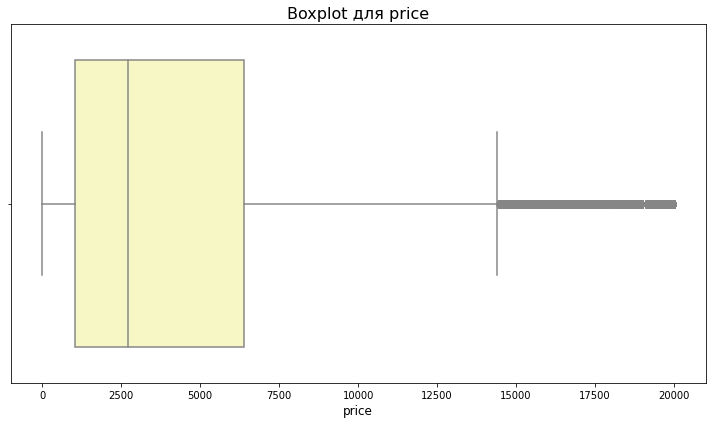

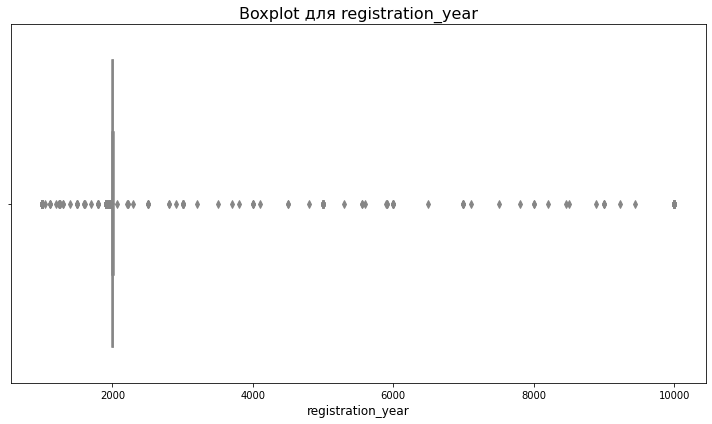

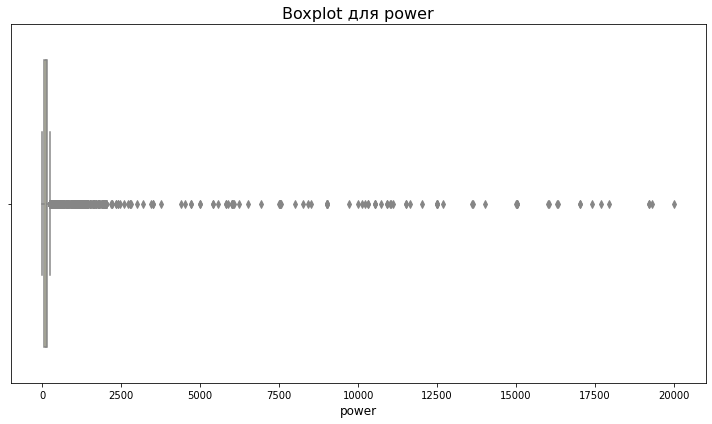

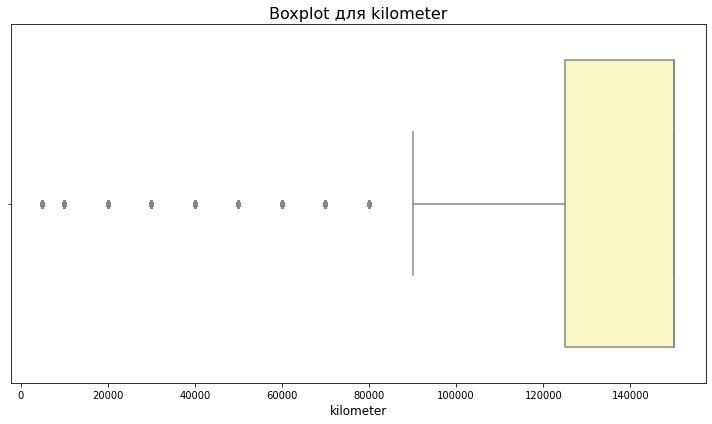

In [14]:
#Проверяем числовые столбцы
numeric_columns = ['price', 'registration_year', 'power', 'kilometer']

for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column], palette="Spectral")
    plt.title(f'Boxplot для {column}', fontsize=16)
    plt.xlabel(column, fontsize=12)
    plt.tight_layout()
    plt.show()

Цена и пробег выглядят приемлемо, не будем трогать.

- Год регистрации автомобиля не может быть Меньше, чем 1900, предположим, что очень старый автомобиль, но и больше текущего года). Сделаем сортировку в рамках **1900 - 2016** гг.

- Мощность, попробуем выставить оптимистично-реалистичные рамки: мнимум: 30 (может стародревний раритет), а максимум 600 (вероятно спортивный автомобиль). Определим рамки **30 - 600**

In [15]:
df = df[(df['registration_year'] >= 1900) & (df['registration_year'] <= 2016)]
df = df[(df['power'] >= 30) & (df['power'] <= 600)]
df = df[(df['price'] != 0)]

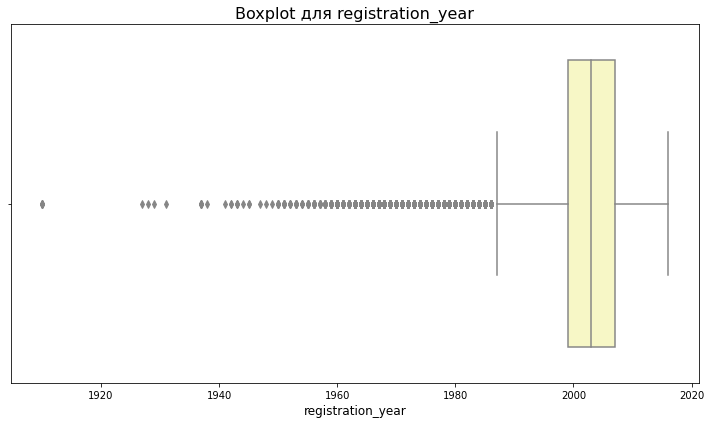

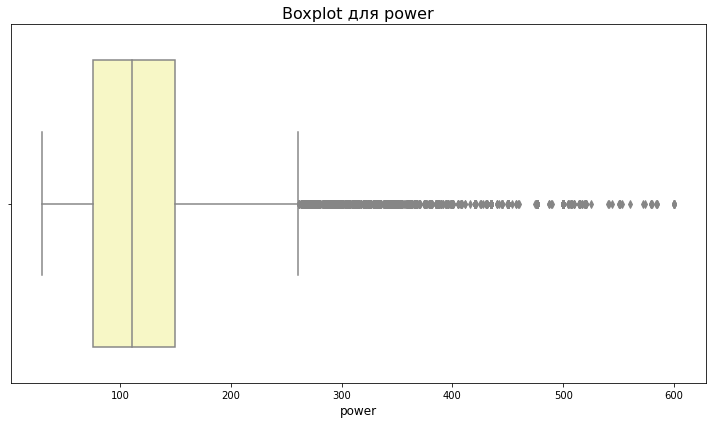

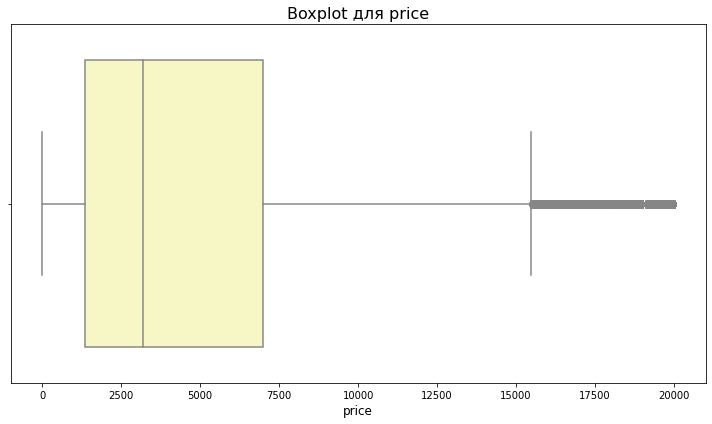

In [16]:
#Еще раз посмотрим 
numeric_columns = ['registration_year', 'power', 'price']

for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column], palette="Spectral")
    plt.title(f'Boxplot для {column}', fontsize=16)
    plt.xlabel(column, fontsize=12)
    plt.tight_layout()
    plt.show()

Есть выбросы, но от откровенных аномалий избавились, оставим раритетный автомобиль в нашем парке. Далее посмотрим как коррелируют наши показатели

### Проверка Корреляции

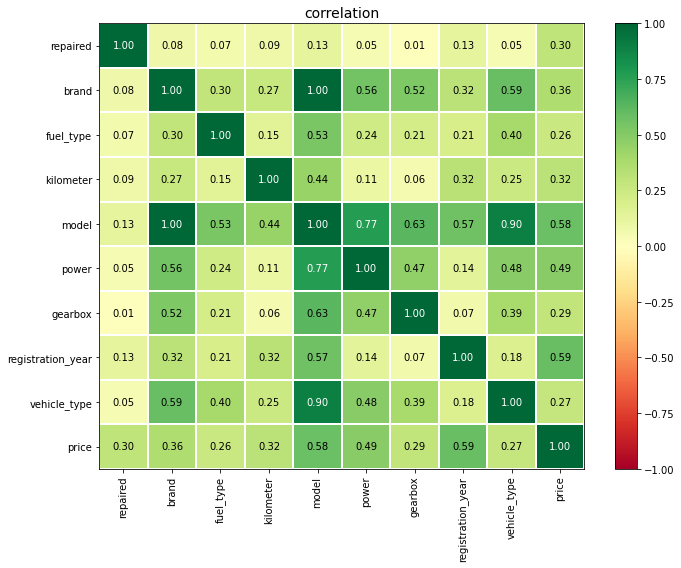

In [17]:
correlation_matrix = df.phik_matrix(interval_cols=['price', 'registration_year', 'power', 'kilometer'])

plot_correlation_matrix(
    correlation_matrix.values,
    x_labels=correlation_matrix.columns,
    y_labels=correlation_matrix.index,
    vmin=-1,
    vmax=1,
    figsize=(10, 8))

Видим силью связь модели и бренда, что логично, у вольксвагена явно будет голф и прочие вариации. Раз особо смысловой нагрузки не несет, избавимся от бренда, чтобы модель обучалась быстрее(важно для заказчика) и эффективнее(важно для нас)

In [18]:
df.drop(columns=['brand'], inplace=True)

df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,no
3,1500,small,2001,manual,75,golf,150000,petrol,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,no
5,650,sedan,1995,manual,102,3er,150000,petrol,yes


Выводы по этапу обработки:

- Загружены необходимые библиотеки и датасет


- Названия колонок приведены к змеиному регистру


- Пустые значения найдены и 5 колонках и заполнены:
 - **repaired** - заменены значения на no
 - **vehicle_type, gearbox, fuel_type, model** - заполнено заглушками **unknown**
 
 
- Найдено и удалено **5** дублирующихся строчек


- Для выполнения задачи были удалены столбцы, которые не несут влияние на прогнозирование цены: **date_crawled, last_seen, number_of_pictures, postal_code, date_created, registration_month**


- Проанализировано распределение, 2 колонки имели аномалии, в следствии чего были скорректированы:
 - **registration_year** - урезаны рамки до 1900 - 2024 гг.
 - **power** - 30 - 600 л.с.
 - удалены значения **price** равные 0
 
 
- Построена матрица корелляции, которая показала сильную взаимосвязь бренда и модели, для улучшения наших предсказаний удалили колонке **brand**

## Обучение моделей

In [19]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

#Сделаем копии, чтобы не было ошибок
X_train = X_train.copy()
X_test = X_test.copy()

#Определим категории
categorical_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']

#Кодируем 
encoder = OrdinalEncoder()
X_train.loc[:, categorical_columns] = encoder.fit_transform(X_train[categorical_columns])
X_test.loc[:, categorical_columns] = encoder.transform(X_test[categorical_columns])

In [20]:
#Параметры
param_distributions_rf = {
    'n_estimators': [50, 100],  # Оставить только два варианта
    'max_depth': [5, 10],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']}

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

#Поиск параметров
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions_rf,
    scoring='neg_mean_squared_error',
    n_iter=4,
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=3)

#Время параметров
start_time = time.time()
rf_random_search.fit(X_train, y_train)
search_time_rf = time.time() - start_time

#Лучшая модель
best_rf_model = rf_random_search.best_estimator_
cv_rmse_rf = np.sqrt(-rf_random_search.best_score_)

#Время обучения
start_time = time.time()
best_rf_model.fit(X_train, y_train)
training_time_rf = time.time() - start_time

#Время предсказания на обучающей выборке
start_time = time.time()
y_pred_train_rf = rf_random_search.best_estimator_.predict(X_train)
prediction_time_train_rf = time.time() - start_time

print()
print(f"Random Forest - Время подбора параметров: {search_time_rf:.2f} сек")
print(f"Random Forest - Время обучения: {training_time_rf:.2f} сек")
print(f"Random Forest - Время предсказания на обучающей выборке: {prediction_time_train_rf:.2f} сек")
print(f"Random Forest - RMSE на кросс-валидации: {cv_rmse_rf:.2f}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   1.7s
[CV 2/3] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   1.7s
[CV 3/3] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   1.7s
[CV 1/3] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   3.4s
[CV 2/3] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   3.4s
[CV 3/3] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   3.4s
[CV 1/3] END max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   3.0s
[CV 2/3] END max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   3.1s
[CV 3/3] END max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   3.0s
[CV 1/3] END max_depth=10

In [21]:
#Параметры
param_distributions_dt = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]}

dt_model = DecisionTreeRegressor(random_state=42)

#Поиск лучших параметров
dt_random_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_distributions_dt,
    scoring='neg_mean_squared_error',
    n_iter=10,
    cv=3,
    random_state=42,
    verbose=3)

#Время параметров
start_time = time.time()
dt_random_search.fit(X_train, y_train)
search_time_dt = time.time() - start_time

#Модель
best_dt_model = dt_random_search.best_estimator_
cv_rmse_dt = np.sqrt(-dt_random_search.best_score_)

#Время обучения
start_time = time.time()
best_dt_model.fit(X_train, y_train)
training_time_dt = time.time() - start_time

#Время предсказания на обучающей выборке
start_time = time.time()
y_pred_train_dt = dt_random_search.best_estimator_.predict(X_train)
prediction_time_train_dt = time.time() - start_time

print()
print(f"Decision Tree - Время подбора параметров: {search_time_dt:.2f} сек")
print(f"Decision Tree - Время обучения: {training_time_dt:.2f} сек")
print(f"Decision Tree - Время предсказания на обучающей выборке: {prediction_time_train_dt:.2f} сек")
print(f"Decision Tree - RMSE на кросс-валидации: {cv_rmse_dt:.2f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END max_depth=5, min_samples_leaf=5, min_samples_split=10; total time=   0.2s
[CV 2/3] END max_depth=5, min_samples_leaf=5, min_samples_split=10; total time=   0.1s
[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=10; total time=   0.1s
[CV 1/3] END max_depth=10, min_samples_leaf=3, min_samples_split=5; total time=   0.3s
[CV 2/3] END max_depth=10, min_samples_leaf=3, min_samples_split=5; total time=   0.2s
[CV 3/3] END max_depth=10, min_samples_leaf=3, min_samples_split=5; total time=   0.3s
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV 3/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV 1/3] END max_depth=None, min_samples_leaf=3, min_samples_split=2; total time=   0.4s
[CV 2/3] END max_depth=None, min_samples_leaf=3, min_samples_split=

In [22]:
#Параметры
param_distributions_lgb = {
    'num_leaves': [15, 31, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]}

lgb_model = LGBMRegressor(objective='regression', random_state=42)

#Поиск лучших параметров
lgb_random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_distributions_lgb,
    scoring='neg_mean_squared_error',
    n_iter=2,
    cv=2,
    random_state=42,
    verbose=2,
    n_jobs=-1)

#Время подбора параметров
start_time = time.time()
lgb_random_search.fit(X_train, y_train)
search_time_lgb = time.time() - start_time

#Лучшая модель
best_lgb_model = lgb_random_search.best_estimator_
cv_rmse_lgb = np.sqrt(-lgb_random_search.best_score_)

#Время обучения
start_time = time.time()
best_lgb_model.fit(X_train, y_train)
training_time_lgb = time.time() - start_time

#Время предсказания на обучающей выборке
start_time = time.time()
y_pred_train_lgb = lgb_random_search.best_estimator_.predict(X_train)
prediction_time_train_lgb = time.time() - start_time

print()
print(f"LightGBM - Время подбора параметров: {search_time_lgb:.2f} сек")
print(f"LightGBM - Время обучения: {training_time_lgb:.2f} сек")
print(f"LightGBM - Время предсказания на обучающей выборке: {prediction_time_train_lgb:.2f} сек")
print(f"LightGBM - RMSE на кросс-валидации: {cv_rmse_lgb:.2f}")


Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END learning_rate=0.01, n_estimators=200, num_leaves=50; total time=  15.3s
[CV] END learning_rate=0.01, n_estimators=200, num_leaves=50; total time=  15.4s
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=31; total time=   5.5s
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=31; total time=   5.5s

LightGBM - Время подбора параметров: 48.61 сек
LightGBM - Время обучения: 5.70 сек
LightGBM - Время предсказания на обучающей выборке: 1.83 сек
LightGBM - RMSE на кросс-валидации: 1751.86


Выводы по этапу обучения модели:

- Выбраны 3 разные модели для предсказания цены:
 - Модель с деревьями решений - **Decision Tree** 
 - Ансамблевая модель - **Random Forest**
 - Модель градиентного бустинга - **LightGBM**
 

- По необходимой метрике лучшая модель - **LightGBM**, с показателем **RMSE: 1751.86**

## Анализ моделей и выводы

In [25]:
#Засунем все в табличку
results_summary_simple = pd.DataFrame({
    'Модель': ['Random Forest', 'Decision Tree', 'LightGBM'],
    'Время обучения (сек)': [training_time_rf, training_time_dt, training_time_lgb],
    'Время предсказания (сек)': [prediction_time_train_rf, prediction_time_train_dt, prediction_time_train_lgb],
    'RMSE на кросс-валидации': [cv_rmse_rf, cv_rmse_dt, cv_rmse_lgb]})

results_summary_simple

,Модель,Время обучения (сек),Время предсказания (сек),RMSE на кросс-валидации
0,Random Forest,7.96,1.81,1945.72
1,Decision Tree,0.55,0.06,1844.92
2,LightGBM,5.70,1.83,1751.86


Лучшую метрику показывает **LightGBM**, берем ее для окончательной рекомендации

In [24]:
#Посмотрим показатель на лучшей модели 
start_time = time.time()
y_pred_test = best_lgb_model.predict(X_test)
test_prediction_time = time.time() - start_time

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"LightGBM - Время предсказания на тестовой выборке: {test_prediction_time:.2f} сек")
print(f"LightGBM - RMSE на тестовой выборке: {rmse_test:.2f}")

LightGBM - Время предсказания на тестовой выборке: 0.61 сек
LightGBM - RMSE на тестовой выборке: 1744.19


На основе полученных результатов можно сделать следующие выводы:

- RandomForest

 - Время обучения: 7.96 сек
 - RMSE: 1945.72
 - Время предсказания на тренировочной выборке 1.81 сек

- DecisionTree
 - **Время обучения: 0.55 сек**
 - RMSE: 1844.92
 - **Время предсказания на тренировочной выборке 0.06 сек**
    
- LightGBM
 - Время обучения: 5.70		сек
 - **RMSE: 1751.86**
 - Время предсказания на тренировочной выборке **1.83 сек**    
 
 
В процессе моделирования важно оценивать:

 - Качество предсказаний (RMSE)
 - Время обучения модели
 - Время предсказания модели

Сравнение моделей

- RandomForest. Показывает быстрое временя обучения **7.96 сек**, но при этом RMSE самое высокое из всех моделей - **1945.72**, скорость предсказания - **1.81 сек**

- LightGBM. Показатель RMSE у этой модели самый низкий среди всех **1751.86**, что делает её приоритетной. Скорость обучения - **0.55**, хороший показатель, как и скорость выдачи предсказания - **1.83 сек**

- DecisionTree. Время обучения у модели и предсказания наименьшее из всех моделей - **0.6 сек** и **0.06 сек**, но RMSE выше, чем у градиентного бустинга 

Рекомендации. На основе указанных критериев можно порекомендовать следующие варианты:

**LightGBM** — наилучшая модель с точки зрения качества предсказаний. Показывает довольно быстрое врмея обучения и предсказания не трениовочной выборке, но при это все в пределах нормы, рекомендуем модель градиентного бустинга. Время предсказаний на тестовой выборке **0.61 сек**, RMSE на тестовой выборке **1744.19**